In [63]:
import pickle
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
from scipy import stats

In [318]:
#experiment,lmt = ['Arabidopsis_GenomeWide_Analysis_euclidean_v8_fixed',0.2]
#experiment,lmt = ['Human_Promoter_Analysis_euclidean_v8',0.08]
#experiment,lmt = ['TAL-GATA_binaryFeat_Analysis_allTFs_euclidean_v8_from_customTFs',0.08]
experiment,lmt = ['Simulated_Data_Analysis_Test',0.12]
num_filters = 200

In [319]:
with open(f'../Results/{experiment}/Interactions_SATORI/main_results_raw.pckl','rb') as f:
    attentions, positions, seqposes = pickle.load(f)
with open(f'../Results/{experiment}/Interactions_SATORI/interaction_keys_dict.pckl', 'rb') as f:
    intr_keys = pickle.load(f)
df_intr = pd.read_csv(f'../Results/{experiment}/Interactions_SATORI/interactions_summary_attnLimit-{lmt}.txt',sep='\t')
filter_ICs = pd.read_csv(f'../Results/{experiment}/Motif_Analysis/table.txt')

In [320]:
df_intr = df_intr[df_intr['adjusted_pval']<0.05].reset_index(drop=True)

In [321]:
df_intr.shape

(119, 12)

In [322]:
raw_col = filter_ICs.columns[0]
cols = ['filter#'] + raw_col.split()
data = filter_ICs[raw_col].apply(lambda x: x.split()).tolist()
filter_ICs = pd.DataFrame(data, columns=cols)
filter_ICs['filter'] = filter_ICs['filter#'].apply(lambda x: f"filter{x}")

In [323]:
filter_ICs.head()

,filter#,consensus,annotation,ic,mean,std,filter
0,0,CTCTCTCCTCAAG,GABPA,10.60,0.2833,0.4824,filter0
1,1,CGGAAGTGAACGT,.,4.00,0.3354,0.5927,filter1
2,2,TTGTAACTAGAAC,.,5.31,0.3221,0.5181,filter2
3,3,GAAGCGAACATTT,.,9.33,0.4287,0.6695,filter3
4,4,GAGTGCCCACCGG,.,3.68,0.2373,0.4133,filter4


In [324]:
def get_query_filter_attn(all_filters_dict, attn_mat, seq_info_dict, feat_size, num_multiheads):
    attn_mat = np.asarray([attn_mat[:,feat_size*i:feat_size*(i+1)] for i in range(0,num_multiheads)]) 
    attn_mat = np.max(attn_mat, axis=0) #out of the 8 attn matrices, get the max value at the corresponding positions

    for i in range(0, attn_mat.shape[0]):
        if i not in seq_inf_dict:
            continue
        for j in range(0, attn_mat.shape[1]):
            if j not in seq_inf_dict:
                continue
            if i==j:
                continue
            max_loc = [i,j]
            attn_val = attn_mat[i,j]
            #pos_diff = CNNfirstpool * abs(max_loc[0]-max_loc[1])
            KeyA = i
            KeyB = j 
            all_filters_pos = seq_inf_dict[KeyA] #query filters
            #all_filters_pos = seq_inf_dict[KeyB] #key filters
            for fltr in all_filters_pos:
                all_filters_dict[fltr].append(attn_val)
    
    return all_filters_dict
            
            #all_filters_posB = seq_inf_dict[KeyB]

##### Pseud-code/logic
For batch in seqposes:
    attn_matrices_batch = read attention matrices for the given batch using arg(batch)  
    for seq_inf_dict,attn_matrix in zip(batch,attn_matrices_batch):  
        query_filter_attn_val_matrix = get_attn_values_function(seq_inf_dict, attn_matrix)  

Once we have attn values for each query filter, use the analysis to generate a scatter plot using query filter IC values vs. the corresponding non-zero attention scores.

In [325]:
all_filters_dict = {f'filter{i}':[] for i in range(0, num_filters)}

In [326]:
num_batches = 10 #len(seqposes) for all batches to check
for i in range(0, len(seqposes)):
    batch_seqposes = seqposes[i]
    with open(f'../Results/{experiment}/Stored_Values/PAttn_batch-{i}.pckl','rb') as f:
        batch_pattn = pickle.load(f)
    num_multiheads = int(batch_pattn.shape[2]/batch_pattn.shape[1])
    feat_size = batch_pattn.shape[1]
    seq_info_dicts = batch_seqposes[0]
    seq_info_dict_indices = batch_seqposes[1]
    info_dict_keys = list(seq_info_dicts.keys())
    for j in range(0, len(seq_info_dict_indices)):
        seq_inf_dict = seq_info_dicts[info_dict_keys[j]]
        attn_mat = batch_pattn[seq_info_dict_indices[j]]
        all_filters_dict = get_query_filter_attn(all_filters_dict,
                                                 attn_mat,
                                                 seq_info_dict,
                                                 feat_size,
                                                 num_multiheads)
    if i >= num_batches:
        break

In [327]:
all_filters_attn = pd.Series(all_filters_dict)

In [328]:
all_filters_attn = all_filters_attn.apply(lambda x: np.array(x))
all_filters_attn = all_filters_attn.apply(lambda x: np.median(x[x>0]))#[x>=0]))

In [329]:
x = filter_ICs['ic'].values.astype(float)
y = all_filters_attn[filter_ICs['filter']].values

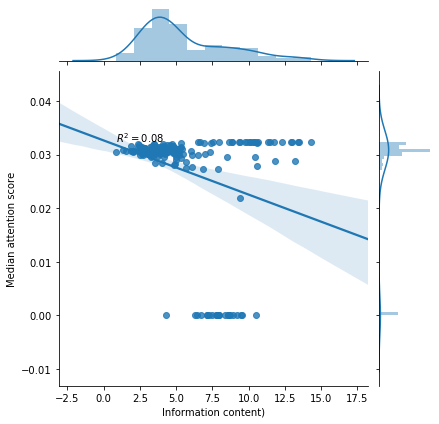

In [330]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

res = pd.DataFrame([x,y]).T
res.columns = ['Information content', 'Median attention score']
sns.jointplot(res['Information content'], res['Median attention score'], kind="reg")
r2val = r2(res['Information content'], res['Median attention score'])
plt.text(min(x),max(y),r'$R^2=$'+str(round(r2val,2)))
plt.xlabel('Information content)')
plt.show()

#### TAL-GATA

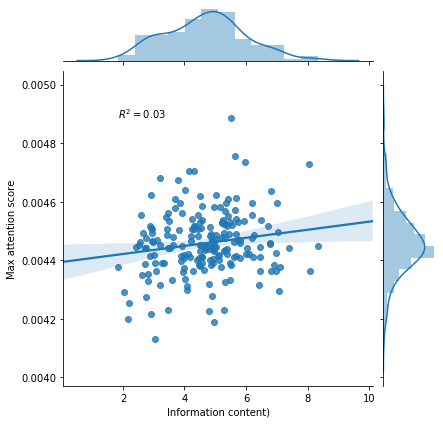

### Human

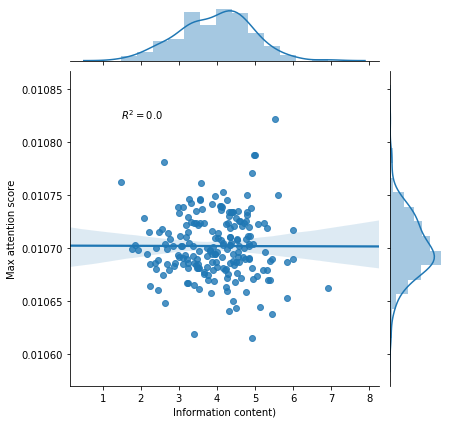

### Arabidopsis

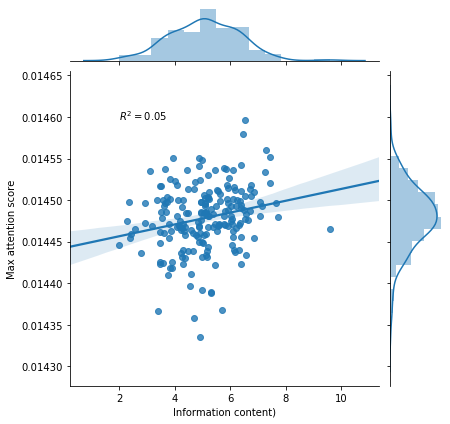